# Bridge regression

In this case we have a model of the form

\begin{equation}
y = X\beta + \epsilon,
\end{equation}

where $y$ is an $n$-dimensional vector, $\beta$ is a $d$-dimensional parameter and $\epsilon_i \sim N(0,\sigma^2)$. The negative log-likelihood is simply $\|y - X\beta\|^2/(2\sigma^2)$.  Combining with an $L_q$ prior for $\beta$ and a suitable choice for the noise $\sigma^2$ and the hyperparameter $\lambda$ controlling prior influence, this gives

\begin{equation}
U(\beta, \sigma^2, \lambda, q) = \frac{1}{2\sigma^2}\|y - X\beta\|^2 + \frac{\lambda}{\sigma^2} \sum_{j=1}^d |\beta_j|^q + c(q) -\frac{d}{2}\log\left(\frac{\lambda}{\sigma^2}\right) + U_0(\sigma) + U_0(q) + U_0(\lambda).
\end{equation}

We consider scenarios in which a dirac prior is placed on $\sigma, \lambda$ and $q$, and then possibly one in which(some of) these are inferred from the data, by using a more diffuse prior. When doing so it is important to specify a conditional prior for $\lambda|\sigma$ to ensure a unimodal posterior, as in Park & Casella (2008).

The simplest realistic example is to probably infer $(\beta,\sigma^2)$ from the data and perform a grid search of possible values for $(\lambda, q)$ from a range of alternatives, validating based on prediction error for a hold out set of data.  More sophisticated methods may be needed for $\lambda$.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# specific functions
import HMC as h
from k_energies import *


# Simple potential class for Bridge regression model (beta only)
class Bridge:
    def __init__(self, h, sigma, q, X, y):
        self.h = h # regularising multiplier
        self.sigma = sigma # observation standard deviation
        self.q = q # regularising power
        self.X = X # design matrix
        self.y = y # response vector
        
    def value(self, beta):
        h = self.h
        sigma = self.sigma
        q = self.q
        X = self.X
        y = self.y
        
        neg_ll = np.sum((y - np.dot(X,beta))**2)/(2*sigma**2)
        beta_prior = (h/sigma**2) * np.sum( np.absolute(beta)**q ) #- len(np.atleast_1d(beta))/2.0 * log(h/sigma**2)
        return neg_ll + beta_prior
        
    def grad(self,beta):
        h = self.h
        sigma = self.sigma
        q = self.q
        X = self.X
        y = self.y
        
        score = 1/(sigma**2) * np.dot( np.transpose(X), y - np.dot(X,beta) )
        d_prior = (h/sigma**2) * q*np.sign(beta)*np.absolute(beta)**(q-1)
        return score + d_prior

x1 = np.random.normal(size=10)
x2 = np.random.normal(size=10)
x = np.empty([10,2])
x[:,0] = x1
x[:,1] = x2
y = 10*x[:,0] + 10*x[:,1] + np.random.normal(size=10)
plt.plot(x[:,0],y,'bo')
plt.plot(x[:,1],y,'ro')

U = Bridge(h = 1, sigma = 1, q = 1.5, X = x, y = y)

print U.grad(np.array([2,3]))
print U.grad(np.array([4,5]))
print U.grad(np.array([0,0]))

RRuntimeError: Error in loadNamespace(name) : there is no package called 'LaplacesDemon'


In [117]:
# test out model on toy example
U = Bridge(h = 0, sigma = 1, q = 2, X = x, y = y)

K_g = Gauss()
#K_rel = GR_family(1)
K_l = Laplace()
K_t = Student(1)

start_vec = np.ones(2)
nits = 10000

samples_g = h.HMC(nits, start_vec, U, K_g, L = 1, e = 0.01) #, BurnIn = 500)
#samples_rel = h.HMC(nits, start_vec, U, K_rel, L = 1, e = 1.5) #, BurnIn = 500)
samples_l = h.HMC(nits, start_vec, U, K_l, L = 1, e = 0.01) #, BurnIn = 500)
samples_t = h.HMC(nits, start_vec, U, K_t, L = 1, e = 0.01) #, BurnIn = 500)

x_samples_g = samples_g['x']
#x_samples_rel = samples_rel['x']
x_samples_l = samples_l['x']
x_samples_t = samples_t['x']

Acceptance rate: 0.572400
LF Steps: 1, Step-size: 0.010
Numerical divergences: 0
Acceptance rate: 0.671500
LF Steps: 1, Step-size: 0.010
Numerical divergences: 0
Acceptance rate: 0.650200
LF Steps: 1, Step-size: 0.010
Numerical divergences: 0


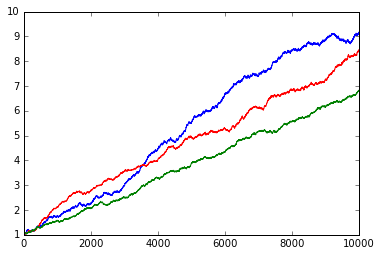

In [118]:
view = 0
plt.plot(x_samples_l[view,:], 'b-', label = "Laplace");
#plt.plot(x_samples_g[0,:], 'b-', label = "Gauss");
plt.plot(x_samples_g[view,:], 'r-', label = "Gauss");
plt.plot(x_samples_t[view,:], 'g-', label = "Student");

## I'm not sure why this isn't working as expected...